In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
import os
from glob import glob
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_mutual_information as nmi
from scipy import ndimage

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

def clip_and_standardize(X, low=0.005, high=0.995, quantiles=True):
    if quantiles:
        X_clp = np.clip(X, np.quantile(X, low), np.quantile(X, high))
    else:
        X_clp = np.clip(X, low, high)
    X_stdz = (X_clp-np.mean(X_clp))/np.std(X_clp)
    
    return X_stdz

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
def make_shell(inner_radius, delta_r, tomo_shape):

    outer_radius = inner_radius+delta_r

    length = min(tomo_shape)
    mask_shape = len(tomo_shape)*[length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for y in range(0, outer_radius+1):
        for x in range(0, outer_radius+1):

            r = np.linalg.norm([y, x])

            if r>=inner_radius and r<outer_radius:
                yidx = y + length//2
                xidx = x + length//2

                _shell_mask[yidx, xidx] = 1

    # first get shell for x>0
    aux = np.rot90(_shell_mask, axes=(0, 1)) + np.rot90(_shell_mask, 2, axes=(0, 1)) + np.rot90(_shell_mask, 3, axes=(0, 1))
    aux2 = _shell_mask + aux 

    # finally, fill the actual shape of the tomogram with the mask
    shell_mask = np.zeros(tomo_shape)
    shell_mask[(tomo_shape[0] - length)//2:(tomo_shape[0] + length)//2,
               (tomo_shape[1] - length)//2:(tomo_shape[1] + length)//2] = aux2
    
    return shell_mask

def make_symmatrix(x, y):
    """Make symmetry matrix following FFT symmetries. Final shape is (y, x)"""
    
    if x%2==1 and y%2==1:
        symmatrix = np.array([-1 for i in range(y*x//2)]+[0]+[1 for i in range(y*x//2)]).reshape(x, y).T
    elif x%2==0 and y%2==1:
        symmatrix = np.array([-1 for i in range(y*(x+1)//2)]+[0]+[1 for i in range(y*(x-1)//2)]).reshape(x, y).T
    elif x%2==0 and y%2==0:
        symmatrix = np.array([-1 for i in range(y*(x+1)//2)]+[1 for i in range(y*(x-1)//2)]).reshape(x, y).T
        symmatrix[y//2, x//2] = 0
    else:
        symmatrix = np.array([-1 for i in range(y*x//2)]+[1 for i in range(y*x//2)]).reshape(x, y).T
        symmatrix[y//2, x//2] = 0
        
    return symmatrix

# Load data

From this moment on, we only focus on 2D XZ slices, where the missing wedge is present.

In [8]:
# spinach cells
cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo10.mrc')
# # Salmonella
# cet_path = os.path.join(ISONET_PATH, 'salmonella_dataset/tomos_deconv/20200213_GW214_tgt4_ali.mrc')

cet = clip_and_standardize(read_array(cet_path))

tomo_shape = cet.shape

yidx = tomo_shape[1]//3
cet = cet[:, yidx, :]

tomo_shape = cet.shape

print(tomo_shape)

(464, 928)


In [4]:
# cet.transpose(1, 0, 2)[:, np.newaxis, :, :].shape

(928, 1, 464, 928)

In [9]:
fft_cet = np.fft.fftshift(np.fft.fftn(cet))
logPower_cet = np.log(np.abs(fft_cet)**2)
logPower_cet = clip_and_standardize(logPower_cet, low=0.001, high=0.999)

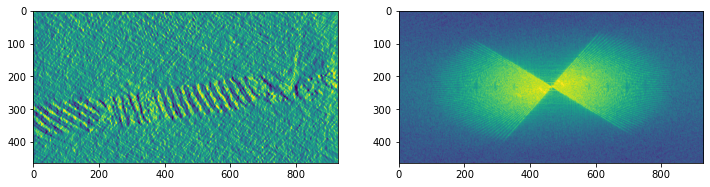

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(cet)
ax[1].imshow(logPower_cet)
plt.show()

# Intensity mask

(array([  3442.,  21357., 101461., 129461.,  61918.,  38960.,  29618.,
         21491.,  15104.,   7780.]),
 array([-2.23559262, -1.69758893, -1.15958524, -0.62158155, -0.08357786,
         0.45442583,  0.99242952,  1.53043321,  2.0684369 ,  2.60644059,
         3.14444428]),
 <BarContainer object of 10 artists>)

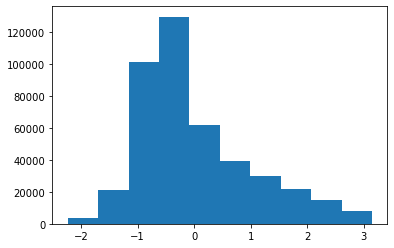

In [49]:
plt.hist(logPower_cet.flatten())

In [107]:
power_mask = (logPower_cet<np.quantile(logPower_cet, 0.95)).astype(int)

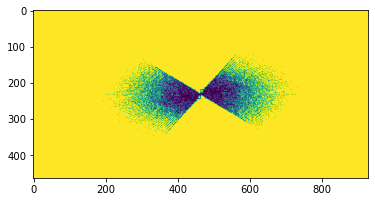

In [108]:
plt.imshow(power_mask)

# Symmask

matrix of {-1, 0, 1}^M*N, with -1, 0, 1 indicating negative frequency components zero frequency component, and positive frequency components, respectively

In [12]:
x = tomo_shape[1]
y = tomo_shape[0]

symmatrix = make_symmatrix(x, y)
np.unique(symmatrix, return_counts=True)

(array([-1,  0,  1]), array([215528,      1, 215063]))

In [14]:
(symmatrix==-1).shape

(464, 928)

# Neighbor mask

For the moment being, I will let every uncorrupted neighbor on the shell. In the future, maybe only neighbors close to the boundary of the missing wedge should be selected.

In [17]:
# corrupted indices are labelled depending on their power
power_mask = (logPower_cet<np.quantile(logPower_cet, 0.95)).astype(int) # yields 1 for corrupted coefficients

symmatrix = make_symmatrix(tomo_shape[1], tomo_shape[0])
neg_mask = (symmatrix==-1).astype(int)

neg_neighbors = []

dr = 3

for inner_radius in tqdm(np.arange(0, min(tomo_shape)//2 - dr, dr)):
    
    # get masks
    ring_mask = make_shell(inner_radius, dr, tomo_shape)
    ring_uncorrupted_mask = (1-power_mask)*ring_mask
    ring_neg_mask = ring_mask*neg_mask
    
    # get neighbors
    ring_neg_nghbrs = np.nonzero(ring_neg_mask.flatten())[0] 
    ring_uncorrupted_nghbrs = np.nonzero(ring_uncorrupted_mask.flatten())[0] 
    
    k = min(len(ring_uncorrupted_nghbrs), 64)
    
    # for each negative neighbor, get a random sample of size k from the uncorrupted neighbors. The first neighbor of a point is itself.
    aux = pd.DataFrame([np.append(n, np.random.choice(ring_uncorrupted_nghbrs[ring_uncorrupted_nghbrs!=n], k))
                        for n in ring_neg_nghbrs], index=ring_neg_nghbrs)
    
    neg_neighbors.append(aux)
    
N_neg = pd.concat(neg_neighbors)

# make a dummy dataframe with all indices corresponding to negative entries from the symmatrix
aux = np.nonzero(neg_mask.flatten())[0]
aux = pd.DataFrame(aux, index=aux)

# get the final data frame with all negative flattened indices
all_N_neg = N_neg.join(aux, how='right', rsuffix='_r')
all_N_neg['0'] = all_N_neg['0_r']
all_N_neg.drop('0_r', axis=1, inplace=True)
all_N_neg.columns = range(65)
all_N_neg = all_N_neg.sort_index()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:09<00:00,  7.93it/s]


(84491, 65)

In [6]:
def make_N_neg_matrix(dr, neg_mask, power_mask):
    """
    Returns a pd.DataFrame of shape (N negative components, 65) with the flattened negative frequency components as the index.
    
    The columns correspond to the index value (own neighbor) and 64 randomly choosen neighbors (NaN whenever no neighbor is present) 
    within a ring of radius 3 of each index value. 
    
    All values are given according to the flattened arrays. We assume that we use ZX slices of YZX images (missing wedge in ZX).
    
    - neg_mask: boolean array with 1 wherever the symmatrix equals -1. Shape: (Z,X)
    - power_mask: boolean array indicating low power coefficients. Shape: (Z,X)
    """
    
    from tqdm import tqdm

    tomo_shape = neg_mask.shape
    
    neg_neighbors = []
    
    for inner_radius in tqdm(np.arange(0, min(tomo_shape)//2 - dr, dr)):

        # get masks
        ring_mask = make_shell(inner_radius, dr, tomo_shape)
        ring_uncorrupted_mask = (1-power_mask)*ring_mask
        ring_neg_mask = ring_mask*neg_mask

        # get neighbors
        ring_neg_nghbrs = np.nonzero(ring_neg_mask.flatten())[0] 
        ring_uncorrupted_nghbrs = np.nonzero(ring_uncorrupted_mask.flatten())[0] 

        k = min(len(ring_uncorrupted_nghbrs), 64)

        # for each negative neighbor, get a random sample of size k from the uncorrupted neighbors. The first neighbor of a point is itself.
        aux = pd.DataFrame([np.append(n, np.random.choice(ring_uncorrupted_nghbrs[ring_uncorrupted_nghbrs!=n], k))
                            for n in ring_neg_nghbrs], index=ring_neg_nghbrs)

        neg_neighbors.append(aux)

    N_neg = pd.concat(neg_neighbors)

    # make a dummy dataframe with all indices corresponding to negative entries from the symmatrix
    aux = np.nonzero(neg_mask.flatten())[0]
    aux = pd.DataFrame(aux, index=aux)

    # get the final data frame with all negative flattened indices
    all_N_neg = N_neg.join(aux, how='right', rsuffix='_r')
    all_N_neg['0'] = all_N_neg['0_r']
    all_N_neg.drop('0_r', axis=1, inplace=True)
    all_N_neg.columns = range(65)
    all_N_neg = all_N_neg.sort_index()
    
    return all_N_neg

In [10]:
dr=3

# corrupted indices are labelled depending on their power
power_mask = (logPower_cet<np.quantile(logPower_cet, 0.95)).astype(int) # yields 1 for corrupted coefficients

symmatrix = make_symmatrix(tomo_shape[1], tomo_shape[0])
neg_mask = (symmatrix==-1).astype(int)

aux = make_N_neg_matrix(dr, neg_mask, power_mask)
aux

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:11<00:00,  6.72it/s]


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430123,430123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430124,430124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430125,430125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430126,430126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
aux.to_numpy()

array([[0.00000e+00,         nan,         nan, ...,         nan,
                nan,         nan],
       [1.00000e+00,         nan,         nan, ...,         nan,
                nan,         nan],
       [2.00000e+00,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [4.30125e+05,         nan,         nan, ...,         nan,
                nan,         nan],
       [4.30126e+05,         nan,         nan, ...,         nan,
                nan,         nan],
       [4.30127e+05,         nan,         nan, ...,         nan,
                nan,         nan]])